# Business Problem 

## The scope of the problem -
1. Identify which questions asked on Quora are duplicates of questions that have already been asked.
2. This could be useful to instantly provide answers to questions that have already been answered. 
3. We are tasked with predicting whether a pair of questions are duplicate or not. 

##### So in a nutshell say if we have question1(Q1) and its answers(A1) then if the second question asked is Q2 then if the second question so asked ie Q2 is similar to Q1 then I will allocate the answer of Q1 ie A1 to Q2. 

## Business Objectives 
1. The cost of misclassification is very high. 
2. You would want a probability of pair of questions to be duplicates so that you can choose any threshold of choice. 
3. No strict latency concerns but it does not mean that the model shall take hours predicting the result.
4. Interpretability is partially important. 

## Data Overview 

1. Data is downloaded from kaggle  - Source : https://www.kaggle.com/c/quora-question-pairs
2. The data we are using in this case study is Train.csv 
3. It is 60 MB in size consist of 404,290 rows and 5 columns. 
4. The 5 columns are - 'Qid1','Qid2','question1','question2','is_duplicate'
5. As we know that the data is represented as D = {x,y} where x represents features and y represents the class lable, here x = 'Qid1','Qid2','question1','question2' and y = 'is_duplicate'

## ML Problem 

#### In this case study we are performing Binary classification ML problem. For a given pair of questions we need to predict if they are duplicate or not.
#### The given questions are given in text so we have to featurize the data such that we are able to perform binary classification.

## Performance Metric
1. The KPI for this case study is Log- Loss 
2. Second important indicator is the confusion matrix. 

## Importing required Libraries 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

## Loading the data and Exploratory Data Analysis 

In [2]:
# avoid decoding problems
# encode questions to unicode
# https://stackoverflow.com/a/6812069
df = pd.read_csv("/Users/ravishaggarwal/Desktop/train_quora.csv",encoding='latin-1')

In [3]:
#the shape of the data 
#there are 6 columns and 404290 rows 
df.shape

(404290, 6)

In [4]:
#printing the first 5 rows with header 
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
#Data information 
#Provided a very limited data 
#features --> id,qid1,qid2,question1,question2
#class label to predict --> is_duplicate 
#As we see in the data information the question2 is 2 less than the question1 this means that there are two NAN values in the 
#question 2 . 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Data Distribution 

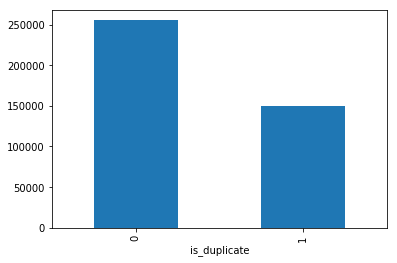

In [6]:
#The plot here shows that there are data points classifies as 0 > data  points classified as 1 
# This means that there are less no of questions which are similar than the questions which are not similar 
df.groupby("is_duplicate")['id'].count().plot.bar()

In [7]:
#Out of total no of question pairs 63.08% pairs are not Similar and 36.92% pairs are similar 
print(' Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

 Question pairs are not Similar (is_duplicate = 0):
   63.08%

 Question pairs are Similar (is_duplicate = 1):
   36.92%


In [9]:
#total no of questions in our data combining qid1 and qid2
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())

In [10]:
#total no of questions in our data (repeated) included 
#there are total 808580 questions included in out data 
len(qids)

808580

In [11]:
qids.value_counts()

2559      157
30782     120
4044      111
2561       88
14376      79
17978      77
2675       68
28764      66
1772       63
24555      61
18753      58
4018       57
28133      56
3595       55
19621      55
18531      55
4951       55
13748      54
10024      54
10330      54
38         54
18296      53
11264      52
6551       52
20190      52
691        51
8461       51
6749       51
2322       51
33412      51
         ... 
95599       1
87403       1
259391      1
89450       1
1345        1
7490        1
13639       1
19784       1
17737       1
23882       1
32078       1
30031       1
34129       1
40274       1
38227       1
42325       1
48470       1
56666       1
54619       1
60764       1
64862       1
62815       1
66913       1
73058       1
77156       1
75109       1
81254       1
85352       1
83305       1
168274      1
Length: 537933, dtype: int64

In [13]:
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 



Max number of times a single question is repeated: 157



In [14]:
#total no of unique questions 

unique_qs = len(np.unique(qids))

In [16]:
#there are 537933 unique questions in our data out of total 808580
unique_qs 
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))

Total number of  Unique Questions are: 537933



In [18]:
#questions that are asked more than one time 
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

In [19]:
#there are 111780 questions that are asked more than one time 
qs_morethan_onetime 

111780

In [20]:
q_vals=qids.value_counts()

q_vals=q_vals.values

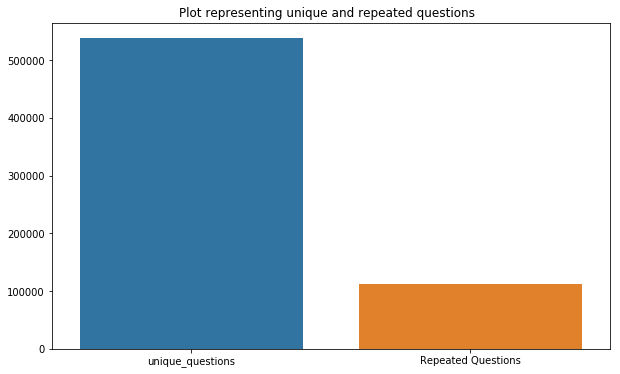

In [22]:
#Pot showing the distribution of the unique questions and repeated questions 
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

## Checkig duplicates 

In [23]:
#checking whether there are any repeated pair of questions 
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


## No. of occurance of each question 

Maximum number of times a single question is repeated: 157



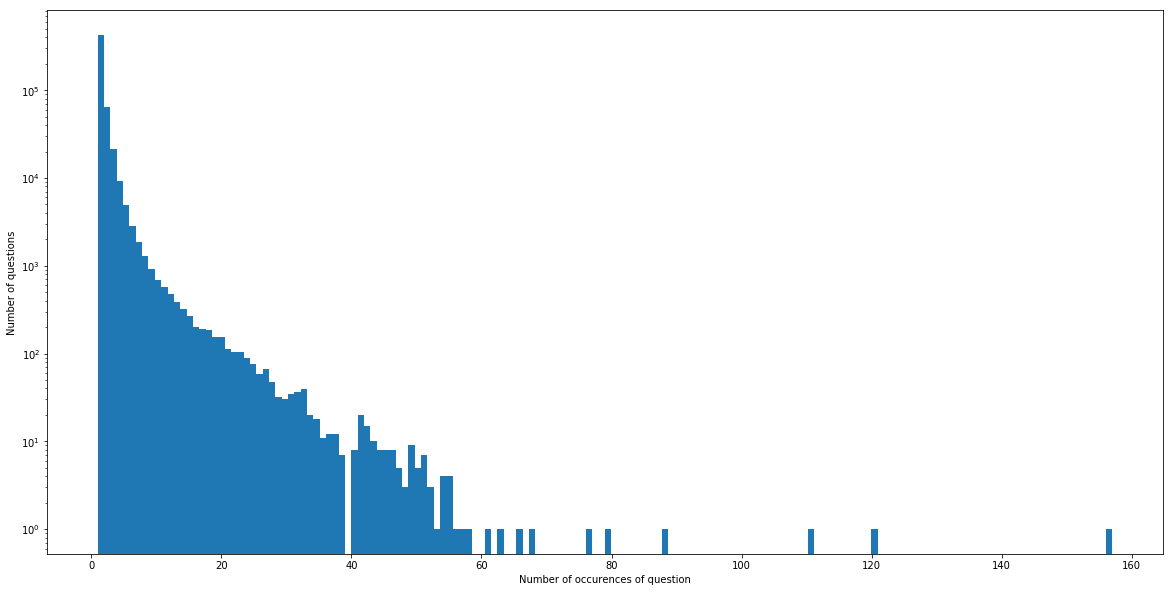

In [26]:
#not exact but somehow it shows a power law distribution 
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

#plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

## Checking for NaN values 

In [27]:
#Checking whether there are any rows with null values
#here are two values in question 2 which are Nan 
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1 question2  \
105780  105780  174363  174364    How can I develop android app?       NaN   
201841  201841  303951  174364  How can I create an Android app?       NaN   

        is_duplicate  
105780             0  
201841             0  


__There are 4 classic way to treat the NaN values in the dataset__
- By simple Imputation where we replace NaN values either by mean, median or replacing value
- By Imputation based on class label where we take mean or median of only those features whose class labels match with the class label of the feature which has NaN value
- By adding theadditional features 
- My Model based Imputation

In [29]:
#NaN treatment 
#replacing the NaN with space 
#We are doing this because the NaN is a text 
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## Feature Engineering- Basic 

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

In [30]:
#Finding the frequency of qid1 
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 



In [31]:
#Finding the frequency of qid2 
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count') 

In [32]:
#finding length of q1 
df['q1len'] = df['question1'].str.len() 



In [33]:
#finding length of q2 
df['q2len'] = df['question2'].str.len()

In [34]:
#finding no of words in question 1 

df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))

In [35]:
#finding no of words in question 2 

df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

In [36]:
# finding word_Common = (Number of common unique words in Question 1 and Question 2)

def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)

In [37]:
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

In [38]:
#word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    

In [39]:
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

In [40]:
#word_share = (word_common)/(word_Total)
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [41]:
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [42]:
#freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']

In [43]:
#freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

__Here with the basic Feature Engineering we are able to create some useful features stated above and now our feature count is 17 from 6__

In [46]:
df.shape

(404290, 17)

In [47]:
#new data set with new features 
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [48]:
#data info after feature engineering 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 17 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
freq_qid1       404290 non-null int64
freq_qid2       404290 non-null int64
q1len           404290 non-null int64
q2len           404290 non-null int64
q1_n_words      404290 non-null int64
q2_n_words      404290 non-null int64
word_Common     404290 non-null float64
word_Total      404290 non-null float64
word_share      404290 non-null float64
freq_q1+q2      404290 non-null int64
freq_q1-q2      404290 non-null int64
dtypes: float64(3), int64(12), object(2)
memory usage: 52.4+ MB


## Analysis of extracted features 

In [49]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Maximum length of the questions in question1 : " , max(df['q1_n_words']))

Minimum length of the questions in question1 :  1
Maximum length of the questions in question1 :  125


In [50]:
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))
print ("Maximum length of the questions in question2 : " , max(df['q2_n_words']))

Minimum length of the questions in question2 :  1
Maximum length of the questions in question2 :  237


In [51]:
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with maximum length [question1] :", df[df['q1_n_words']== 125].shape[0])

Number of Questions with minimum length [question1] : 67
Number of Questions with maximum length [question1] : 1


In [52]:
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])
print ("Number of Questions with maximum length [question2] :", df[df['q2_n_words']== 237].shape[0])

Number of Questions with minimum length [question2] : 24
Number of Questions with maximum length [question2] : 13


### ploting the distribution of word share
### feature - word share 

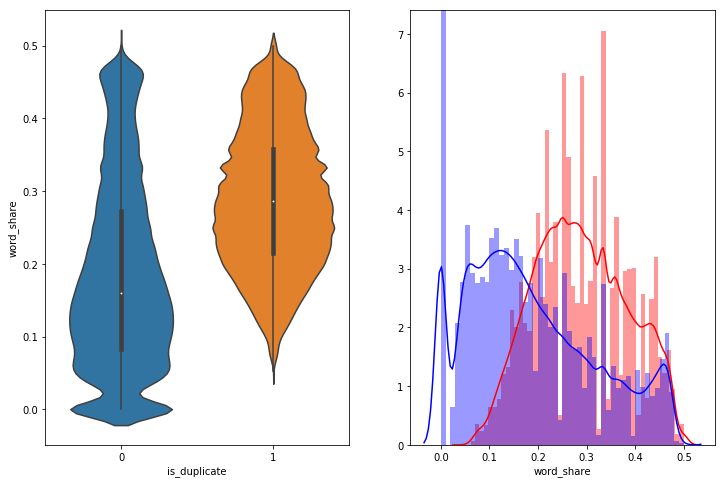

In [53]:
#ploting the distribution of word share 

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- Blue - word share for class 0 data points 
- Red - word share for class 1 data points 
- word share increases then the chances that questions are similar also increases 
- we see in the plot that the word share overlaps a lot on the right hang side shows that there are greater chances of question similarity  

### ploting the word common 
### feature word common 

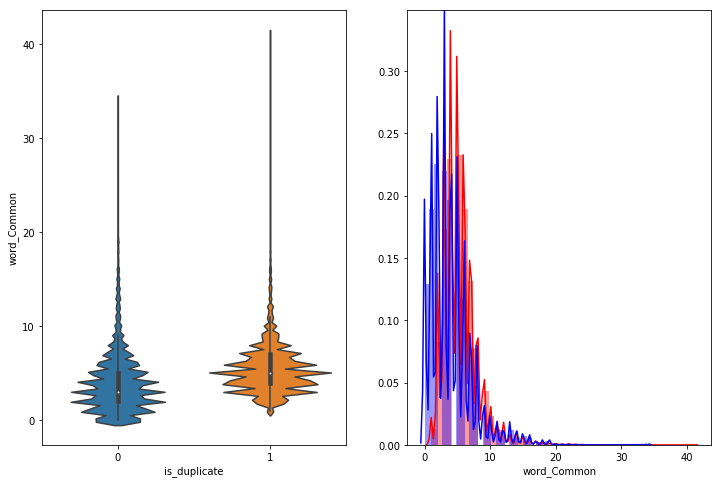

In [54]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>
<p> Which also states the similar thing that if the two questions have similar words then chances of them to be similar are more but here context also plays a major role. As we see in the similar and non similar questions the overlap in the common words are pretty much high </p>

## Advance Featurization Part 1 
### Text Preprocessing 
- Preprocessing the text 
- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [57]:
# To get the results in 4 decemal points
from nltk.corpus import stopwords
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)  #to parse and extract the data from the HTML pages 
        x = example1.get_text()
               
    
    return x
    

## Advanced Feature Extraction Part 2 

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))



In [58]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

In [59]:

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)



In [60]:
def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [61]:
new_df = extract_features(df)

token features...
fuzzy features..


In [63]:
new_df.shape

(404290, 32)

In [64]:
new_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [65]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 32 columns):
id                      404290 non-null int64
qid1                    404290 non-null int64
qid2                    404290 non-null int64
question1               404290 non-null object
question2               404290 non-null object
is_duplicate            404290 non-null int64
freq_qid1               404290 non-null int64
freq_qid2               404290 non-null int64
q1len                   404290 non-null int64
q2len                   404290 non-null int64
q1_n_words              404290 non-null int64
q2_n_words              404290 non-null int64
word_Common             404290 non-null float64
word_Total              404290 non-null float64
word_share              404290 non-null float64
freq_q1+q2              404290 non-null int64
freq_q1-q2              404290 non-null int64
cwc_min                 404290 non-null float64
cwc_max                 404290 non-null float64
csc

__after the advance feature engineering now we have 32 features__

## Ploting word clouds 

In [67]:
df_duplicate = df[df['is_duplicate'] == 1]

In [68]:
df_nonduplicate = df[df['is_duplicate'] == 0]

In [69]:
# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([df_nonduplicate["question1"], df_nonduplicate["question2"]]).flatten()




In [190]:
#Saving the np array into a text file
np.savetxt('/Users/ravishaggarwal/Desktop/train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('/Users/ravishaggarwal/Desktop/train_n.txt', n, delimiter=' ', fmt='%s')

In [70]:
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [71]:
#reading the text files
d = path.dirname('.')
textp_w = open(path.join(d, 'train_p.txt'), encoding="ISO-8859-1").read()
textn_w = open(path.join(d, 'train_n.txt'),encoding="ISO-8859-1").read()
#manipulating stop words 
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")

In [72]:
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110116
Total number of words in non duplicate pair questions : 33211233


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


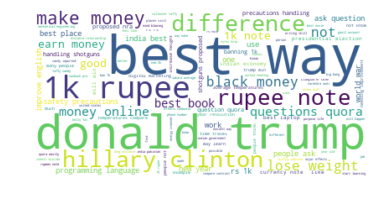

In [73]:
#word count for Duplicate Question pairs 
#gives us the idea about which words are appearing in high frequencies in the questions which has high similarity
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


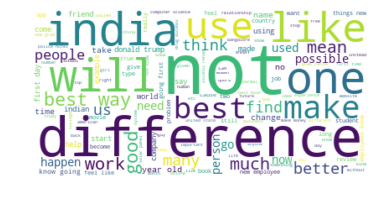

In [60]:
#word count for non Duplicate Question pairs 
#gives us the idea about which words are appearing in high frequencies in the questions which has least similarity
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__understanding the relation between the new features__
- cwc_min
- cwc_max
- csc_max
- csc_min
- ctc_min
- ctc_max
- is_duplicate

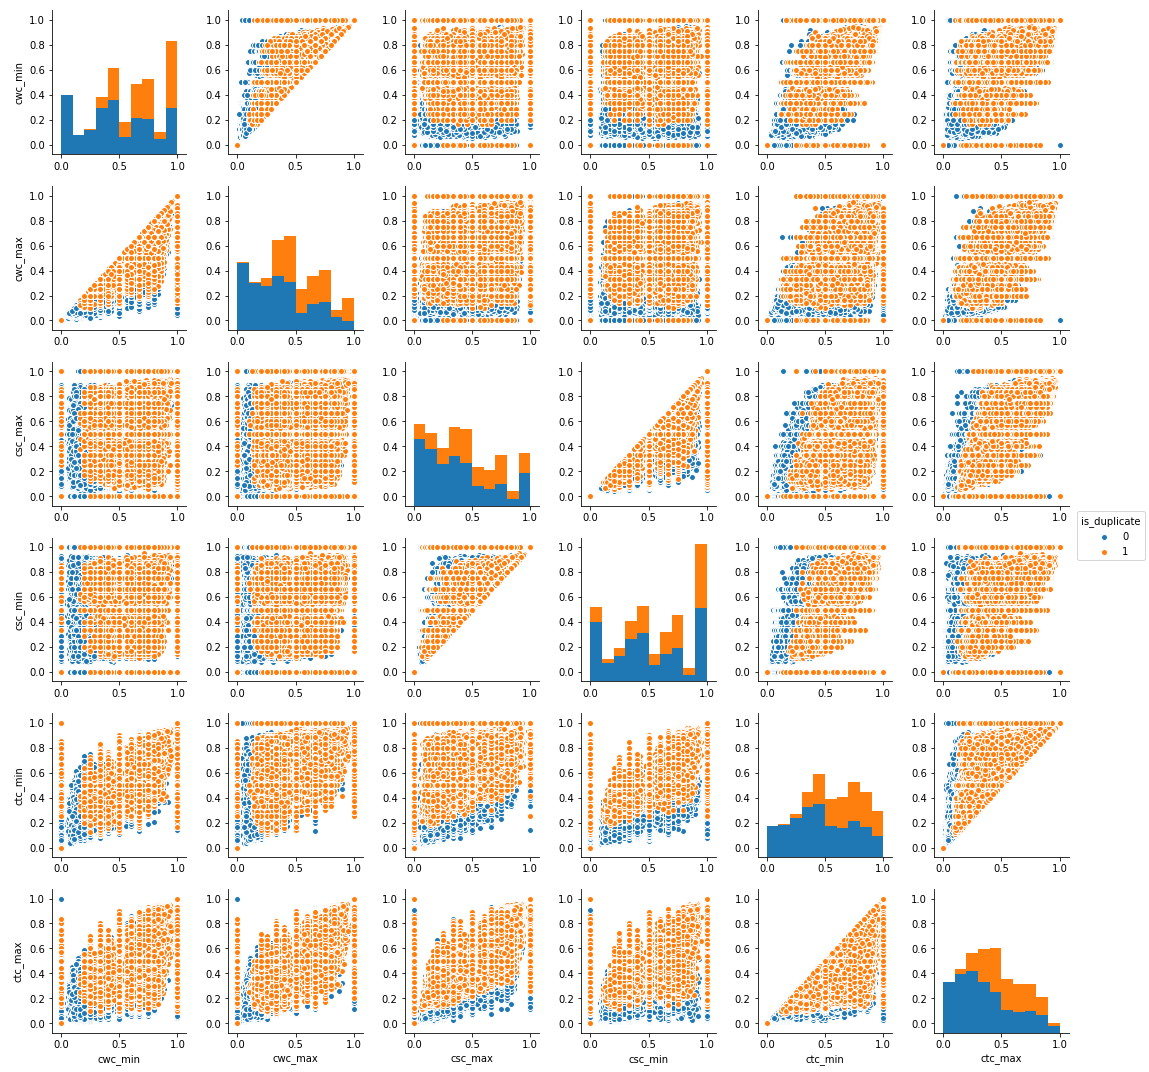

In [61]:
#in most of the cases there is a lot of feature overlaps 
n = new_df.shape[0]
sns.pairplot(df[['cwc_min','cwc_max','csc_max','csc_min','ctc_min','ctc_max', 'is_duplicate']][0:n], hue='is_duplicate', vars=['cwc_min','cwc_max','csc_max','csc_min','ctc_min','ctc_max'])
plt.show()

__understanding the relation between the new features__
- last_word_eq            
- first_word_eq           
- abs_len_diff            
- mean_len
- is_duplicate




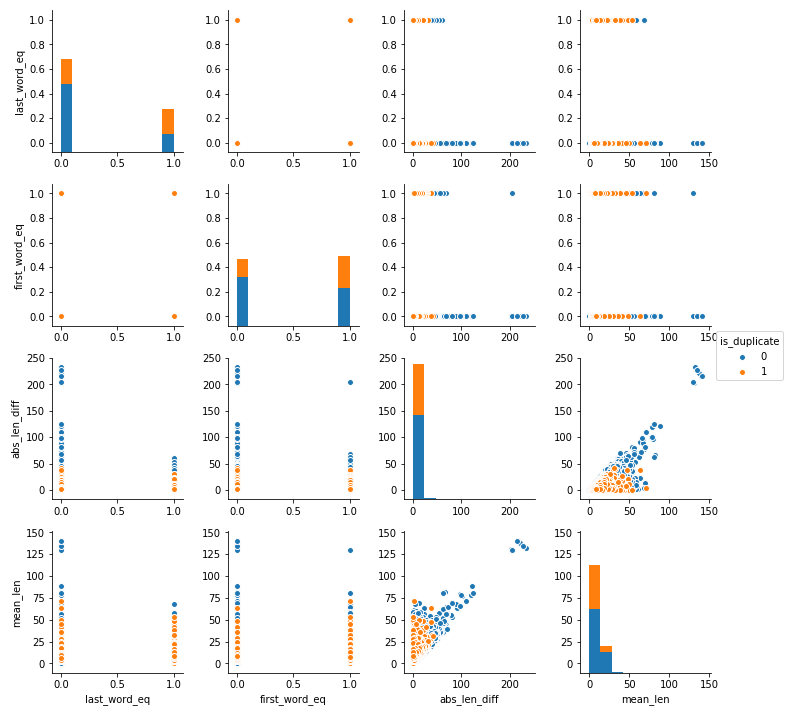

In [62]:
n = new_df.shape[0]
sns.pairplot(df[['last_word_eq','first_word_eq','abs_len_diff','mean_len','is_duplicate']][0:n], hue='is_duplicate', vars=['last_word_eq','first_word_eq','abs_len_diff','mean_len'])
plt.show()

__understanding the relation between the new features__
- token_set_ratio            
- token_sort_ratio           
- fuzz_ratio           
- fuzz_partial_ratio
- longest_substr_ratio

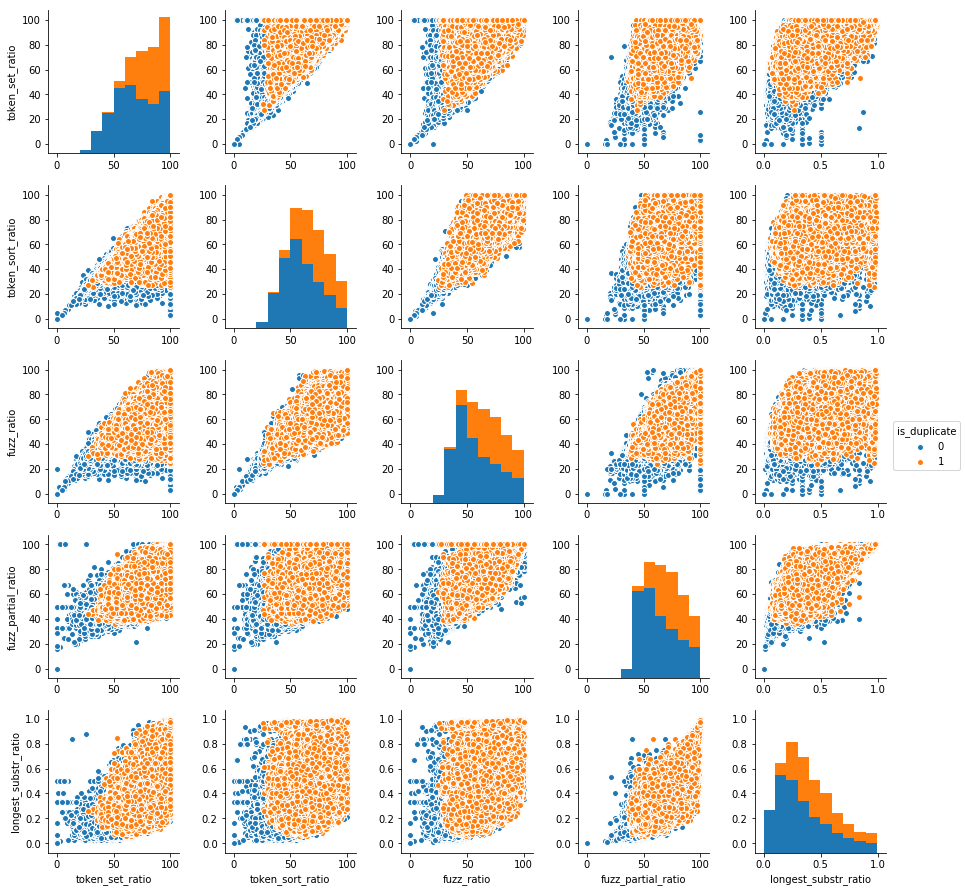

In [63]:
n = new_df.shape[0]
sns.pairplot(df[['token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','is_duplicate']][0:n], hue='is_duplicate', vars=['token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio'])
plt.show()

__Understanding the distribution of all the features__

__cwc_min__

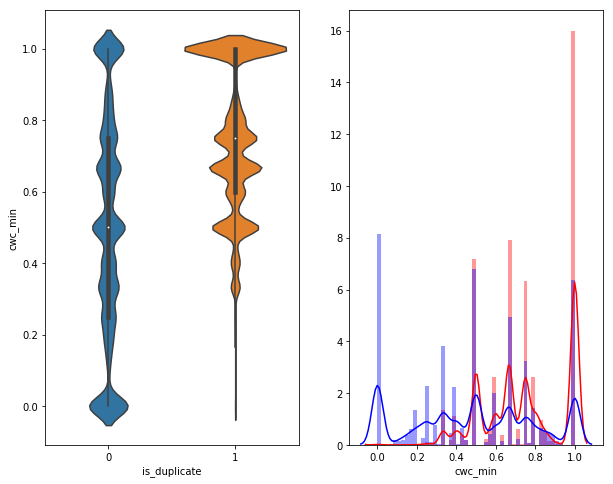

In [65]:
# Distribution of the cwc_min
#on the right side of the plot there is a high overlap 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'cwc_min', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['cwc_min'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['cwc_min'][0:] , label = "0" , color = 'blue' )
plt.show()

__cwc_max__

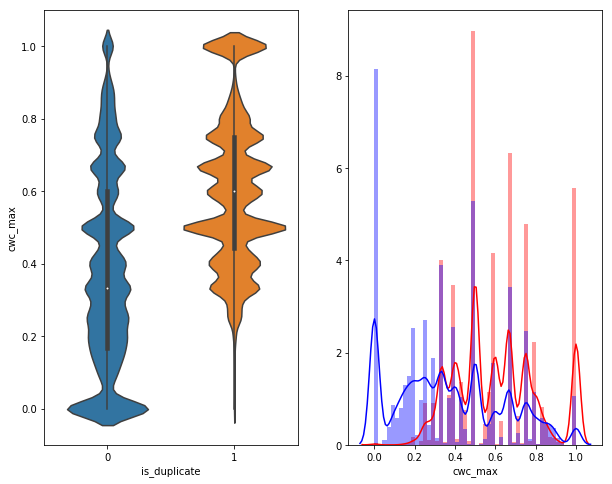

In [66]:
# Distribution of the cwc_max
#on the right side of the plot there is a high overlap 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'cwc_max', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['cwc_max'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['cwc_max'][0:] , label = "0" , color = 'blue' )
plt.show()

__csc_max__

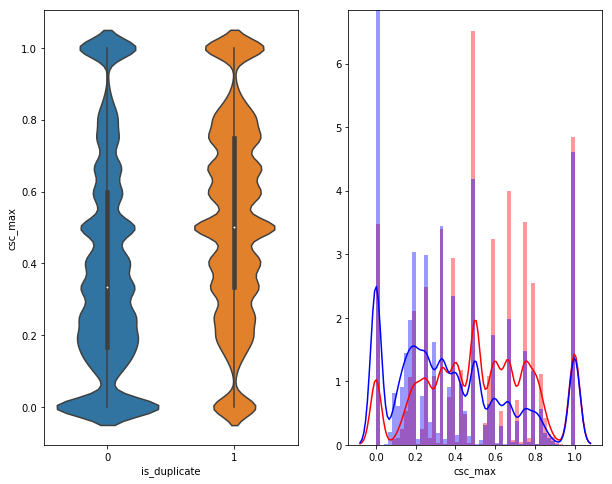

In [67]:
# Distribution of the csc_max
#the plot there is a high overlap 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'csc_max', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['csc_max'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['csc_max'][0:] , label = "0" , color = 'blue' )
plt.show()

__csc_min__

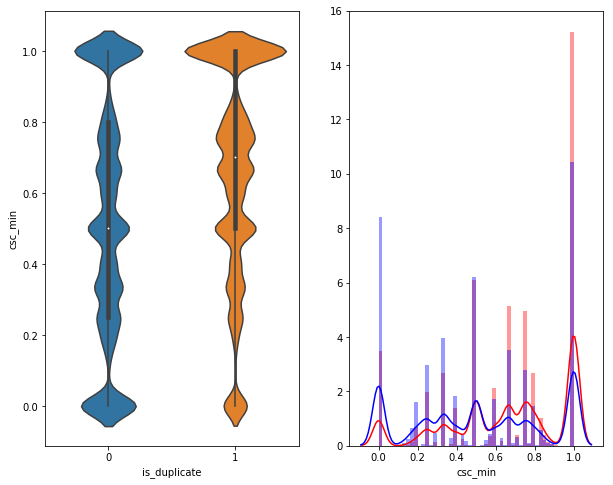

In [68]:
# Distribution of the csc_min
#the plot there is a high overlap 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'csc_min', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['csc_min'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['csc_min'][0:] , label = "0" , color = 'blue' )
plt.show()

__ctc_min__

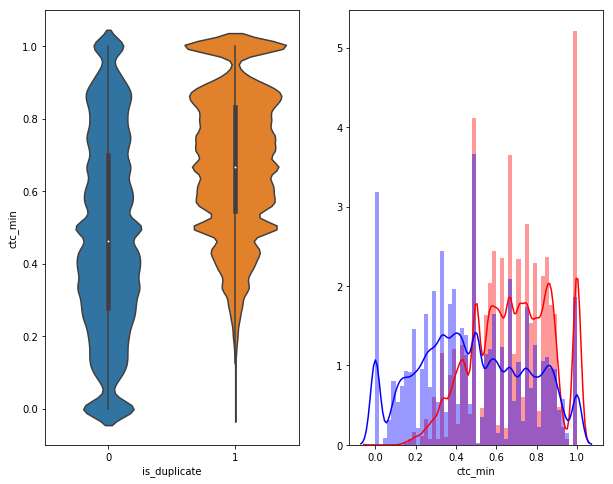

In [69]:
# Distribution of the ctc_min
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'ctc_min', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['ctc_min'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['ctc_min'][0:] , label = "0" , color = 'blue' )
plt.show()

__ctc_max__

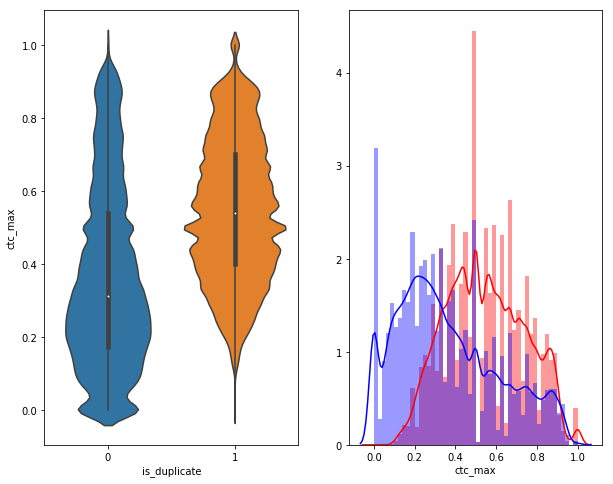

In [70]:
# Distribution of the ctc_max
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'ctc_max', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['ctc_max'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['ctc_max'][0:] , label = "0" , color = 'blue' )
plt.show()

__last_word_eq__

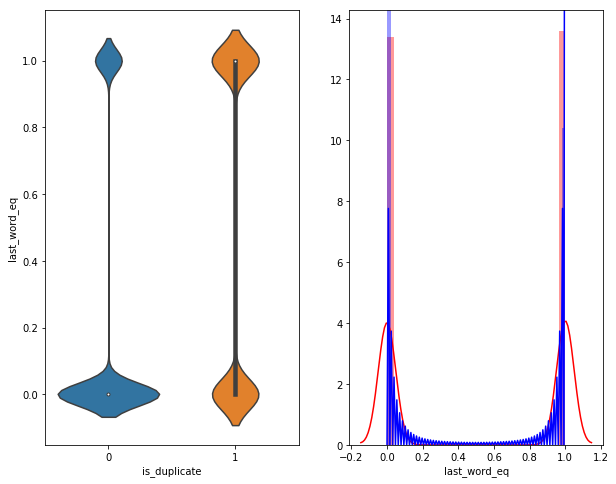

In [71]:
# Distribution of the ctc_max
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'last_word_eq', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['last_word_eq'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['last_word_eq'][0:] , label = "0" , color = 'blue' )
plt.show()

__first_word_eq__

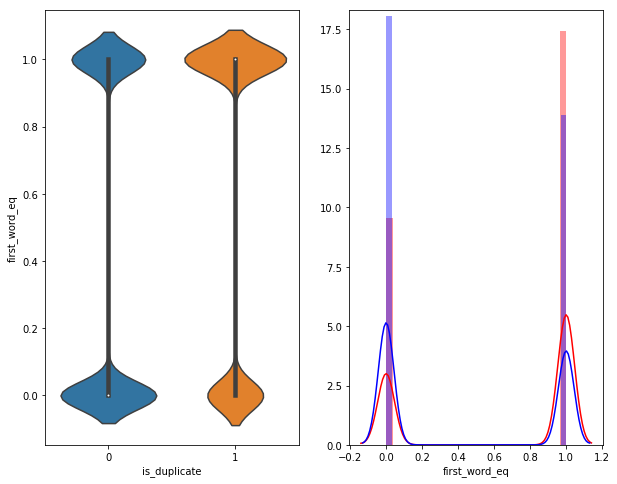

In [72]:
# Distribution of the ctc_max
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'first_word_eq', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['first_word_eq'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['first_word_eq'][0:] , label = "0" , color = 'blue' )
plt.show()

__abs_len_diff__

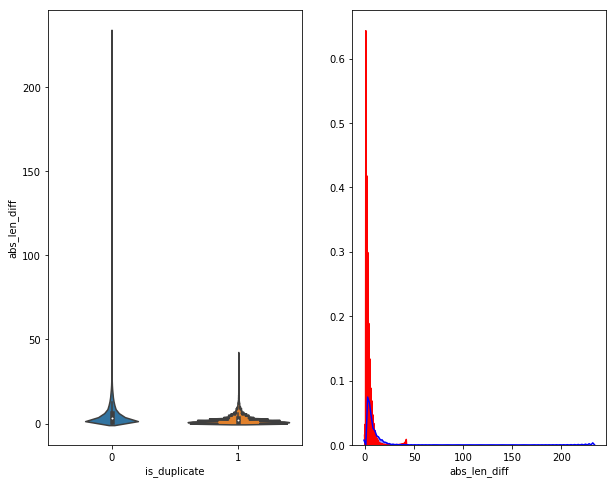

In [73]:
# Distribution of the ctc_max
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'abs_len_diff', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['abs_len_diff'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['abs_len_diff'][0:] , label = "0" , color = 'blue' )
plt.show()

__mean_len__

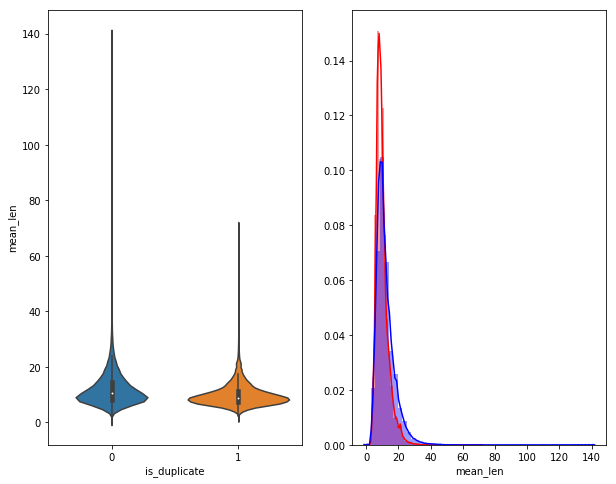

In [74]:
# Distribution of the mean_len
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'mean_len', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['mean_len'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['mean_len'][0:] , label = "0" , color = 'blue' )
plt.show()

__token_set_ratio__

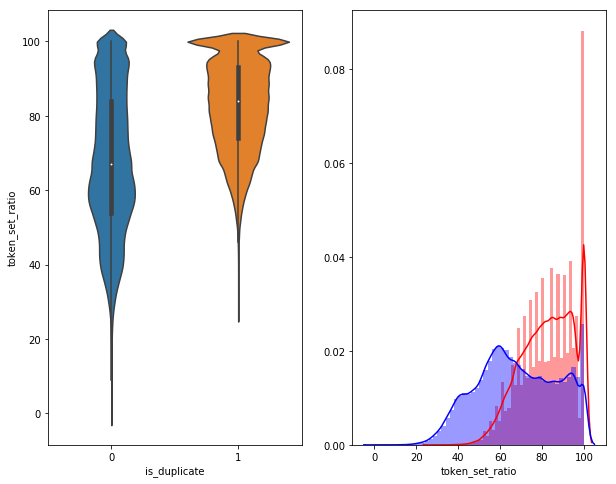

In [75]:
# Distribution of the token_set_ratio
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_set_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['token_set_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['token_set_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

__token_sort_ratio__

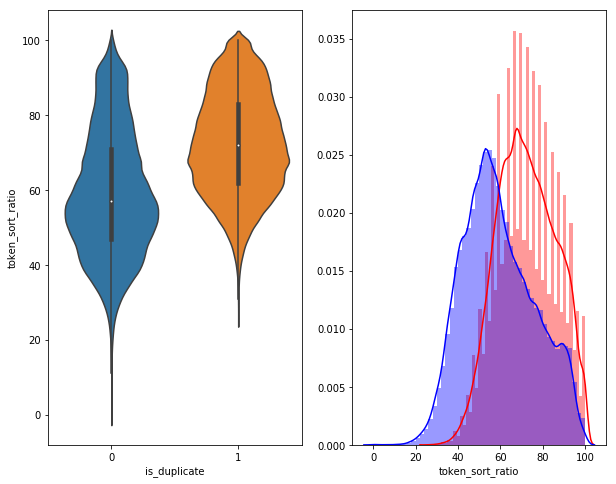

In [77]:
# Distribution of the token_sort_ratio
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

__fuzz_ratio__

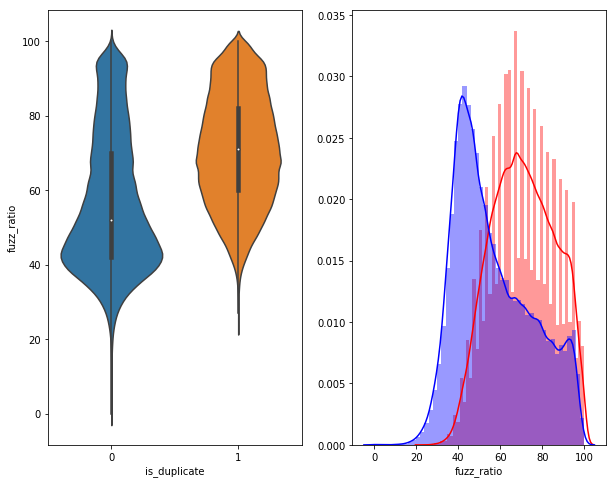

In [78]:
# Distribution of the fuzz_ratio
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

__fuzz_partial_ratio__

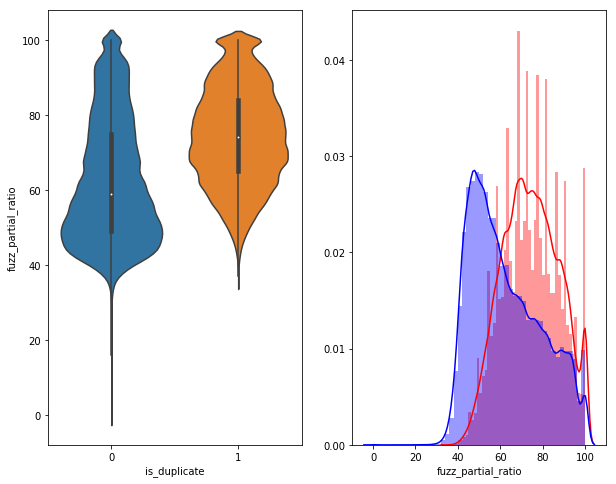

In [79]:
# Distribution of the fuzz_partial_ratio
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_partial_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['fuzz_partial_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['fuzz_partial_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

__longest_substr_ratio__

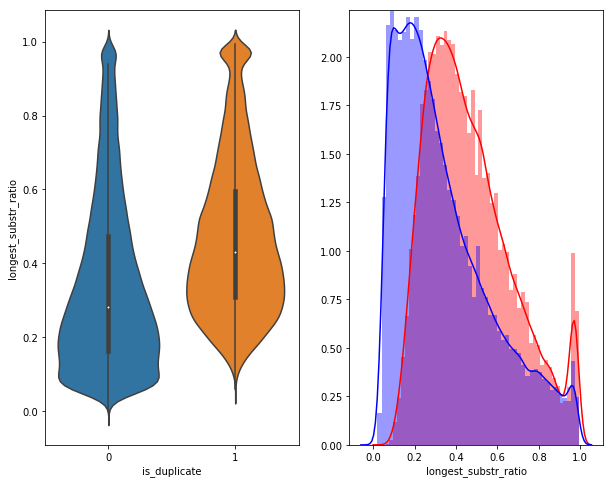

In [80]:
# Distribution of the longest_substr_ratio
#the plot there is a high overlap but in some regions it is fairly separable 
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'longest_substr_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[new_df['is_duplicate'] == 1.0]['longest_substr_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[new_df['is_duplicate'] == 0.0]['longest_substr_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

__important features are__
- cwc_min
- cwc_max
- csc_min
- csc_max
- ctc_min
- ctc_max
- last_word_eq
- first_word_eq
- abs_len_diff
- mean_len
- token_set_ratio
- token_sort_ratio
- fuzz_ratio
- fuzz_partial_ratio
- longest_substr_ratio


- In our advanced exploratory data analysis we featurize 15 new features-
- From out distributional graphs above we conclude that these 15 features are of consequently some importance 
- now using TSNE we will try to plot 15 dimension data to 2 d plot and study the plot 

## TSNE 15 to 2

In [86]:
#selecting 15 important columns from the new_df data frame 
new_data = new_df[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio','is_duplicate']].copy()

In [87]:
new_data.shape

(404290, 16)

In [88]:
new_data.head(5)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,is_duplicate
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759,0
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154,0
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216,0
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000,0


In [89]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention
#randomply sampling 5000 data points
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = new_data[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [90]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...
[t-SNE] Computed neighbors for 5000 samples in 0.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116497
[t-SNE] Computed conditional probabilities in 0.169s
[t-SNE] Iteration 50: error = 80.9807053, gradient norm = 0.0427677 (50 iterations in 8.114s)
[t-SNE] Iteration 100: error = 70.3732147, gradient norm = 0.0086232 (50 iterations in 5.817s)
[t-SNE] Iteration 150: error = 68.5849991, gradient norm = 0.0060796 (50 iterations in 5.945s)
[t-SNE] Iteration 200: error = 67.7157516, gradient norm = 0.0038348 (50 iterations in 5.794s)
[t-SNE] Iteration 250: error = 67.2160873, gradient norm = 0.0036205

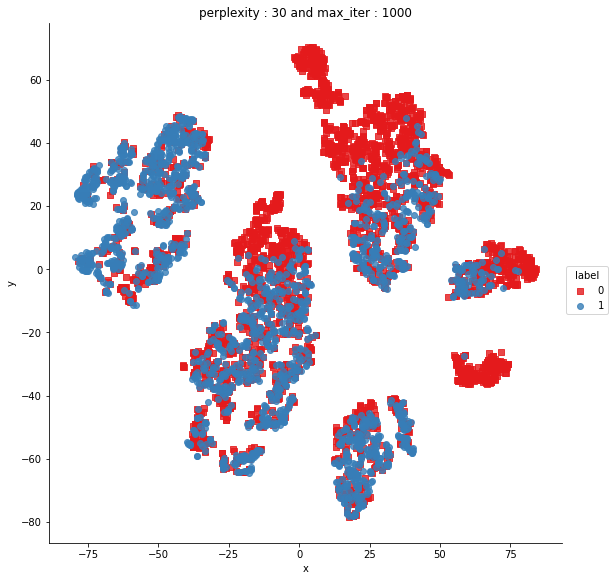

In [91]:
df_tsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df_tsne, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

## Fancy 3D visulaization

In [92]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.388s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116497
[t-SNE] Computed conditional probabilities in 0.172s
[t-SNE] Iteration 50: error = 80.3767090, gradient norm = 0.0306064 (50 iterations in 14.598s)
[t-SNE] Iteration 100: error = 69.1272430, gradient norm = 0.0033524 (50 iterations in 7.127s)
[t-SNE] Iteration 150: error = 67.6735764, gradient norm = 0.0018196 (50 iterations in 6.643s)
[t-SNE] Iteration 200: error = 67.0788269, gradient norm = 0.0011509 (50 iterations in 6.658s)
[t-SNE] Iteration 250: error = 66.7518311, gradient norm = 0.000893

In [93]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

## This is the part2 of the project where we will be focusing on Vectorization and Machine Learning aspect

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [75]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 32 columns):
id                      404290 non-null int64
qid1                    404290 non-null int64
qid2                    404290 non-null int64
question1               404290 non-null object
question2               404290 non-null object
is_duplicate            404290 non-null int64
freq_qid1               404290 non-null int64
freq_qid2               404290 non-null int64
q1len                   404290 non-null int64
q2len                   404290 non-null int64
q1_n_words              404290 non-null int64
q2_n_words              404290 non-null int64
word_Common             404290 non-null float64
word_Total              404290 non-null float64
word_share              404290 non-null float64
freq_q1+q2              404290 non-null int64
freq_q1-q2              404290 non-null int64
cwc_min                 404290 non-null float64
cwc_max                 404290 non-null float64
csc

<h2>Featurizing text data with tfidf weighted word-vectors </h2>

In [76]:
# avoid decoding problems
# encode questions to unicode
# https://stackoverflow.com/a/6812069

new_df.head(5)




,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,...,0.000000,0.0,0.0,2.0,12.0,36,36,35,40,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,...,0.307690,0.0,1.0,6.0,10.0,67,47,46,56,0.175000


In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(new_df['question1']) + list(new_df['question2'])

In [78]:
questions

['what is the step by step guide to invest in share market in india ',
 'what is the story of kohinoor  koh i noor  diamond ',
 'how can i increase the speed of my internet connection while using a vpn ',
 'why am i mentally very lonely  how can i solve it ',
 'which one dissolve in water quikly sugar  salt  methane and carbon di oxide ',
 'astrology  i am a capricorn sun cap moon and cap rising   what does that say about me ',
 'should i buy tiago ',
 'how can i be a good geologist ',
 'when do you use ã   instead of ã   ',
 'motorola  company   can i hack my charter motorolla dcx3400 ',
 'method to find separation of slits using fresnel biprism ',
 'how do i read and find my youtube comments ',
 'what can make physics easy to learn ',
 'what was your first sexual experience like ',
 'what are the laws to change your status from a student visa to a green card in the us  how do they compare to the immigration laws in canada ',
 'what would a trump presidency mean for current internatio

In [79]:
tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

<808580x87933 sparse matrix of type '<class 'numpy.float64'>'
	with 8179963 stored elements in Compressed Sparse Row format>

In [80]:
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [81]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
#the en_vectors_web_lg model provides 300-dimensional GloVe vectors for over 1 million terms of English.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(new_df['question1'])):
    doc1 = nlp(qu1)
    
    
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
   

    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)


100%|██████████| 404290/404290 [1:08:46<00:00, 97.97it/s]


In [82]:
new_df['q1_feats_m'] = list(vecs1)

In [83]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 33 columns):
id                      404290 non-null int64
qid1                    404290 non-null int64
qid2                    404290 non-null int64
question1               404290 non-null object
question2               404290 non-null object
is_duplicate            404290 non-null int64
freq_qid1               404290 non-null int64
freq_qid2               404290 non-null int64
q1len                   404290 non-null int64
q2len                   404290 non-null int64
q1_n_words              404290 non-null int64
q2_n_words              404290 non-null int64
word_Common             404290 non-null float64
word_Total              404290 non-null float64
word_share              404290 non-null float64
freq_q1+q2              404290 non-null int64
freq_q1-q2              404290 non-null int64
cwc_min                 404290 non-null float64
cwc_max                 404290 non-null float64
csc

In [84]:
vecs2 = []
for qu2 in tqdm(list(new_df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

100%|██████████| 404290/404290 [1:43:21<00:00, 65.19it/s]  


In [85]:
new_df['q2_feats_m'] = list(vecs2)

In [86]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 34 columns):
id                      404290 non-null int64
qid1                    404290 non-null int64
qid2                    404290 non-null int64
question1               404290 non-null object
question2               404290 non-null object
is_duplicate            404290 non-null int64
freq_qid1               404290 non-null int64
freq_qid2               404290 non-null int64
q1len                   404290 non-null int64
q2len                   404290 non-null int64
q1_n_words              404290 non-null int64
q2_n_words              404290 non-null int64
word_Common             404290 non-null float64
word_Total              404290 non-null float64
word_share              404290 non-null float64
freq_q1+q2              404290 non-null int64
freq_q1-q2              404290 non-null int64
cwc_min                 404290 non-null float64
cwc_max                 404290 non-null float64
csc

__Getting the final_data that has 795 features __

In [150]:
df1 = new_df.drop(['q1_feats_m','q2_feats_m'],axis=1)

In [151]:
df1.shape

(404290, 32)

In [152]:
df_q1 = pd.DataFrame(new_df.q1_feats_m.values.tolist(), index= new_df.index)


In [153]:
df_q1.shape

(404290, 384)

In [154]:
df_q2 = pd.DataFrame(new_df.q2_feats_m.values.tolist(), index= new_df.index)

In [155]:
df_q2.shape

(404290, 384)

In [156]:
#df1['id'] = new_df['id']
df_q1['id']=df1['id']
df_q2['id']=df1['id']

In [157]:
df_new = df1.merge(df_q1,on='id',how='left')

In [158]:
final_df = df_new.merge(df_q2,on='id',how='left')

In [159]:
#we shall get rid of some features which are not usefull from the final_df

final_data = final_df.drop(['id','qid1','qid2','question1','question2'],axis=1)

In [160]:
final_data.shape

(404290, 795)

In [161]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Columns: 795 entries, is_duplicate to 383_y
dtypes: float64(782), int64(13)
memory usage: 2.4 GB


## Proceeding to the machine learning with our final_data

__final_df data frame has following type of features__

- Basic EDA features 
- Advanced EDA features 
- TFIDF W2V score of question 1 
- TFIDF W2V score of question 2 
- Class Lable to predict is_duplicate

In [162]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [163]:
#considering data final_df 

final_data.shape

(404290, 795)

__Converting strings to numericals__

In [164]:
cols = list(final_data.columns)
for i in cols:
    final_df[i] = final_df[i].apply(pd.to_numeric)
    print(i)
    
   


is_duplicate
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
96_x
97_x
98_x
99_x
100_x
101_x
102_x
103_x
104_x
105_x
106_x
107_x
108_x
109_x
110_x
111_x
112_x
113_x
114_x
115_x
116_x
117_x
118_x
119_x
120_x
121_x
122_x
123_x
124_x
125_x
126_x
127_x
128_x
129_x
130_x
131_x
132_x
133_x
13

In [165]:
y_true = final_data['is_duplicate']
final_data = final_data.drop(['is_duplicate'],axis=1)

In [166]:
final_data.shape

(404290, 794)

In [167]:
#final_df = final_data.reset_index()

<h2>Random train test split( 70:30) </h2>


In [168]:
X_train,X_test, y_train, y_test = train_test_split(final_data, y_true, stratify=y_true, test_size=0.3)

In [169]:
np.where(np.isnan(X_train))


(array([  3609,   3609,   3609, ..., 260542, 260542, 260542]),
 array([ 26,  27,  28, ..., 791, 792, 793]))

In [171]:
X_train_noNan= X_train.fillna(X_train.mean())

In [172]:
np.where(np.isnan(X_train_noNan))

(array([], dtype=int64), array([], dtype=int64))

In [173]:
np.where(np.isnan(X_test))

(array([  2009,   2009,   2009, ..., 103651, 103651, 103651]),
 array([ 26,  27,  28, ..., 791, 792, 793]))

In [174]:
X_test_noNan= X_test.fillna(X_test.mean())

In [175]:
np.where(np.isnan(X_test_noNan))

(array([], dtype=int64), array([], dtype=int64))

In [176]:
np.where(np.isnan(y_train))

(array([], dtype=int64),)

In [177]:
np.where(np.isnan(y_test))

(array([], dtype=int64),)

In [179]:
print("Number of data points in train data :",X_train_noNan.shape)
print("Number of data points in test data :",X_test_noNan.shape)

Number of data points in train data : (283003, 794)
Number of data points in test data : (121287, 794)


In [180]:
print("Number of data points in class label train: ",y_train.shape)
print("Number of data points in class label test: ",y_test.shape)

Number of data points in class label train:  (283003,)
Number of data points in class label test:  (121287,)


In [181]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in test data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [182]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

__We made a random model that will take input any number and provide output predicted_y__
__The goal of designing a random model is to calculate the worst case scenario of the log loss__
__The log loss function here is 0.88 so in a smart model which is ofcourse better than the random model__
__The log loss value should be less than 0.88__

In [183]:
predicted_y = np.zeros((test_len,2))

In [192]:
predicted_y.shape

(121287,)

Log loss on Test Data using Random Model 0.884691391717


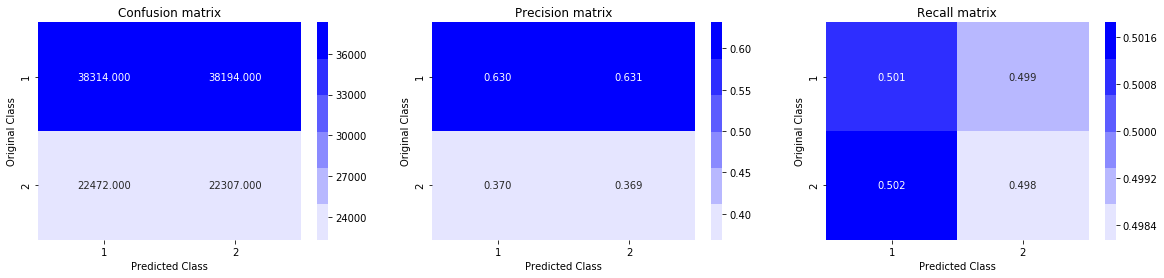

In [197]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

In [203]:
sum(rand_probs)[0]

0.82606225076525941

# <h2> Logistic Regression with hyperparameter tuning </h2>

In [188]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train_noNan, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_noNan, y_train)
    predict_y = sig_clf.predict_proba(X_test_noNan)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



For values of alpha =  1e-05 The log loss is: 0.48503926697
For values of alpha =  0.0001 The log loss is: 0.490747098738
For values of alpha =  0.001 The log loss is: 0.487696450254
For values of alpha =  0.01 The log loss is: 0.493061305304
For values of alpha =  0.1 The log loss is: 0.485619372159
For values of alpha =  1 The log loss is: 0.471976488843
For values of alpha =  10 The log loss is: 0.509955819577


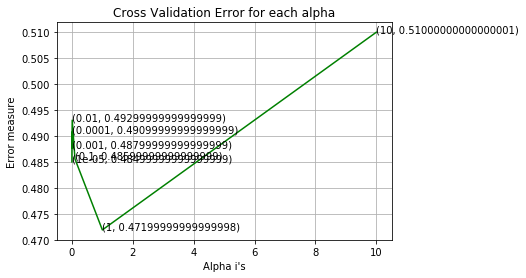

For values of best alpha =  1 The train log loss is: 0.471963231574
For values of best alpha =  1 The test log loss is: 0.471976488843
Total number of data points : 121287


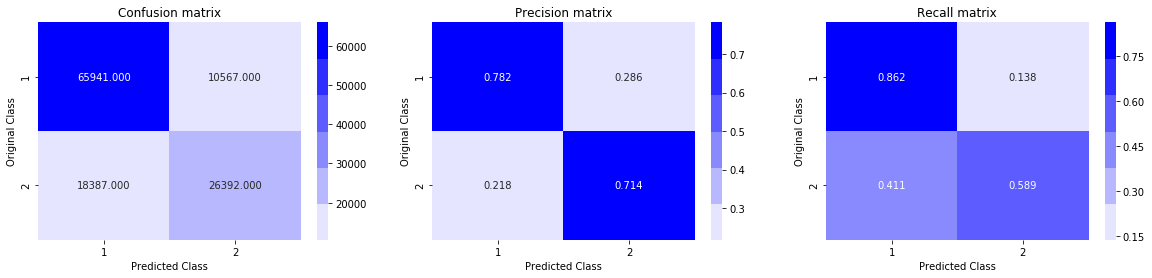

In [190]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train_noNan, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_noNan, y_train)

predict_y = sig_clf.predict_proba(X_train_noNan)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_noNan)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

__Since the train and test log loss are very close to each other this means that the model is neither underfitting or overfitting__